This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds three raw data coordinate estimation models: one each for m/z, RT, and scan.

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
#     classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found by grid search: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [5]:
file_sequence_charge_attribs_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/coordinate-estimators/merged-run-library-sequence-attribs.pkl')

In [6]:
file_sequence_charge_attribs_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'run_intensity', 'cv_mz', 'cv_scan', 'cv_rt', 'cv_intensity',
       'theoretical_mz', 'experiment_scan_mean', 'experiment_scan_std_dev',
       'experiment_scan_peak_width', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_rt_peak_width',
       'experiment_intensity_mean', 'experiment_intensity_std_dev',
       'number_of_runs_identified', 'q_value', 'delta_mz', 'delta_mz_ppm',
       'delta_scan', 'delta_rt'],
      dtype='object')

In [7]:
file_sequence_charge_attribs_df.file_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [8]:
file_idx = 0

#### X is the same for all the estimators

In [9]:
# filter out rows not to be used in this training set
file_sequence_charge_attribs_df = file_sequence_charge_attribs_df[(file_sequence_charge_attribs_df.file_idx == file_idx) & (file_sequence_charge_attribs_df.number_of_runs_identified > 5)]

X = file_sequence_charge_attribs_df[['theoretical_mz','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','experiment_intensity_mean','experiment_intensity_std_dev']].values
y = file_sequence_charge_attribs_df[['delta_mz_ppm','delta_scan','delta_rt','run_mz','run_scan','run_rt']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
file_sequence_charge_attribs_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_intensity,cv_mz,cv_scan,cv_rt,...,experiment_rt_std_dev,experiment_rt_peak_width,experiment_intensity_mean,experiment_intensity_std_dev,number_of_runs_identified,q_value,delta_mz,delta_mz_ppm,delta_scan,delta_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608639,74.415000,600.28,164401.000000,8.976665e-09,0.000873,0.000100,...,5.337039,17.374444,125019.777778,58280.792111,7,0.000003,-0.000087,-0.073821,0.010311,-0.003720
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532289,156.663333,486.69,53927.333333,6.659680e-08,0.013789,0.000058,...,3.195292,6.357111,62104.977778,10240.988909,20,0.000003,0.000163,0.160203,-0.020025,-0.005971
2,0,AAAAAWEEPSSGNGTAR,2,823.381841,535.110000,367.24,267193.000000,0.000000e+00,0.000000,0.000000,...,2.885489,6.129302,328849.938963,88335.911724,20,0.000003,-0.000035,-0.042087,0.002816,-0.010323
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112865,468.230000,997.18,250956.000000,0.000000e+00,0.000000,0.000000,...,1.079070,6.400476,169897.333333,61422.767750,9,0.000003,-0.000178,-0.199050,0.008492,-0.000524
4,0,AAAEDVNVTFEDQQK,2,832.892072,488.330000,471.79,106272.000000,0.000000e+00,0.000000,0.000000,...,2.937441,8.617143,146153.692852,140254.885141,17,0.000003,0.000346,0.415758,0.002609,-0.005279


#### m/z delta estimation model - estimate the m/z delta ppm as a proportion of the experiment-wide value

In [11]:
y_train_delta_mz_ppm = y_train[:,0]
y_test_delta_mz_ppm = y_test[:,0]

In [12]:
best_mz_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
# use the best parameters to train the model
best_mz_estimator.fit(X_train, y_train_delta_mz_ppm)
print("R-squared for training set (best model found): {}".format(best_mz_estimator.score(X_train, y_train_delta_mz_ppm)))

R-squared for training set (best model found): 0.9941861789087295


In [14]:
# use the trained model to predict the m/z delta ppm for the test set
y_test_predicted_delta_mz_ppm = best_mz_estimator.predict(X_test)

In [15]:
mz_df = pd.DataFrame()
mz_df['predicted_delta_mz_ppm'] = y_test_predicted_delta_mz_ppm  # the estimated delta
mz_df['delta_rt'] = y_test_delta_mz_ppm  # the actual delta
mz_df['actual_mz'] = y_test[:,3]  # the actual mz
mz_df['experiment_mz'] = X_test[:,0]  # the experiment (theoretical) mz
mz_df['estimated_mz'] = (mz_df.predicted_delta_mz_ppm / 1e6 * mz_df.experiment_mz) + mz_df.experiment_mz
mz_df['error_mz_ppm'] = (mz_df.estimated_mz - mz_df.actual_mz) / mz_df.actual_mz * 1e6

In [16]:
# calculate the RMSE (Root Mean Square Error, or the standard deviation of the residuals)
np.std(mz_df.error_mz_ppm)

1.0860512687999324

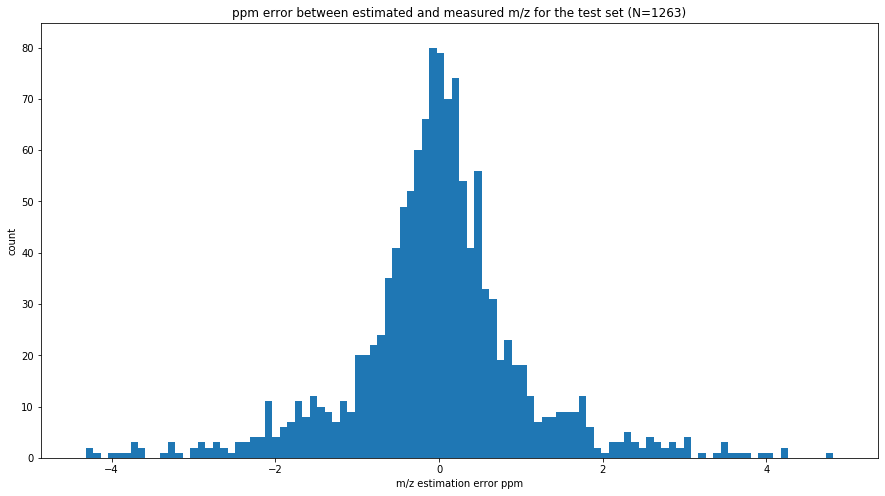

In [17]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm error between estimated and measured m/z for the test set (N={})'.format(len(y_test_predicted_delta_mz_ppm)))

bins = 100
hist, bins, _ = plt.hist(mz_df.error_mz_ppm, bins=bins, label='m/z estimation error')
plt.xlabel('m/z estimation error ppm')
plt.ylabel('count')

plt.show()

#### scan estimation model - estimate the delta scan as a proportion of the experiment-wide value

In [18]:
y_train_delta_scan = y_train[:,1]
y_test_delta_scan = y_test[:,1]

In [19]:
best_scan_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
# use the best parameters to train the model
best_scan_estimator.fit(X_train, y_train_delta_scan)
print("R-squared for training set (best model found): {}".format(best_scan_estimator.score(X_train, y_train_delta_scan)))

R-squared for training set (best model found): 0.9995026396871697


In [21]:
# use the trained model to predict the scan for the test set
y_test_predicted_delta_scan = best_scan_estimator.predict(X_test)

In [22]:
scan_df = pd.DataFrame()
scan_df['predicted_delta_scan'] = y_test_predicted_delta_scan
scan_df['delta_scan'] = y_test_delta_scan
scan_df['actual_scan'] = y_test[:,4]
scan_df['experiment_scan'] = X_test[:,3]
scan_df['estimated_scan'] = (scan_df.predicted_delta_scan * scan_df.experiment_scan) + scan_df.experiment_scan
scan_df['error_scan'] = scan_df.estimated_scan - scan_df.actual_scan

In [23]:
# calculate the RMSE (Root Mean Square Error, or the standard deviation of the residuals)
np.std(scan_df.error_scan)

6.43342108646945

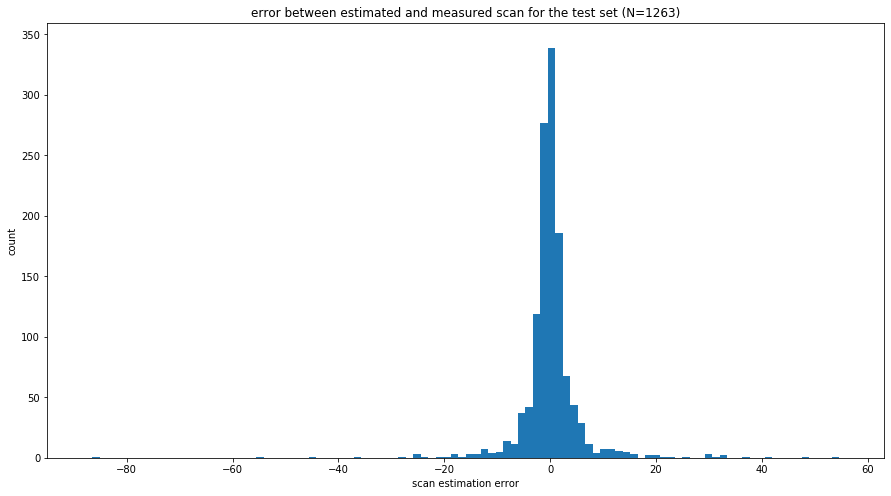

In [24]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('error between estimated and measured scan for the test set (N={})'.format(len(y_test_predicted_delta_scan)))

bins = 100
hist, bins, _ = plt.hist(scan_df.error_scan, bins=bins, label='scan error')
plt.xlabel('scan estimation error')
plt.ylabel('count')

plt.show()

#### RT estimation model - estimate the RT delta as a proportion of the experiment-wide value

In [25]:
y_train_delta_rt = y_train[:,2]
y_test_delta_rt = y_test[:,2]

In [26]:
best_rt_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
# use the best parameters to train the model
best_rt_estimator.fit(X_train, y_train_delta_rt)
print("R-squared for training set (best model found): {}".format(best_rt_estimator.score(X_train, y_train_delta_rt)))

R-squared for training set (best model found): 0.9974296594661036


In [28]:
# use the trained model to predict the scan for the test set
y_test_predicted_delta_rt = best_rt_estimator.predict(X_test)

In [29]:
rt_df = pd.DataFrame()
rt_df['predicted_delta_rt'] = y_test_predicted_delta_rt
rt_df['delta_rt'] = y_test_delta_rt
rt_df['actual_rt'] = y_test[:,5]
rt_df['experiment_rt'] = X_test[:,1]
rt_df['estimated_rt'] = (rt_df.predicted_delta_rt * rt_df.experiment_rt) + rt_df.experiment_rt
rt_df['error_rt'] = rt_df.estimated_rt - rt_df.actual_rt

In [30]:
# calculate the RMSE (Root Mean Square Error, or the standard deviation of the residuals)
np.std(rt_df.error_rt)

5.376422361870001

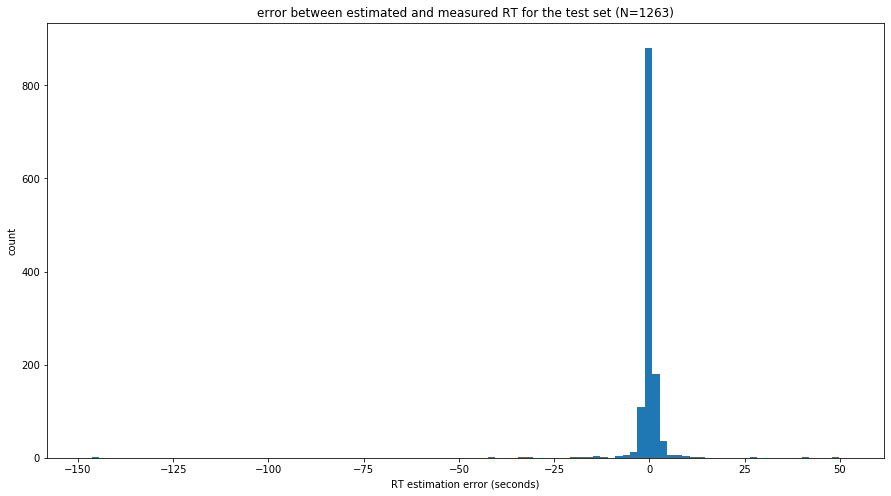

In [31]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('error between estimated and measured RT for the test set (N={})'.format(len(y_test_predicted_delta_rt)))

bins = 100
hist, bins, _ = plt.hist(rt_df.error_rt, bins=bins, label='RT error')
plt.xlabel('RT estimation error (seconds)')
plt.ylabel('count')

plt.show()